In [1]:
%matplotlib notebook

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import theano
from theano import config
import theano.tensor as T
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import time
from scipy.optimize import minimize
from climin.util import optimizer

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [3]:
from schlichtanders.myoptimizers import online, batch
from schlichtanders.myfunctools import compose

In [4]:
from theano_models import softplus, softplus_inv, total_size, as_tensor_variable, reparameterize_map

from theano_models.postmaps import scipy_postmap, climin_postmap, flat_numericalize_postmap, flatten_parameters, probabilistic_optimizer_postmap

import theano_models.probabilistic_models as pm
import theano_models.deterministic_models as dm

# Testing Gauss Distribution

For this test we simply try to approximate a diagonal gaussian distribution to given gaussian samples.

## model

In [5]:
size = 2
model = pm.DiagGauss(size)
model

{ 'inputs': [],
  'logP': <FunctionWrapper at 0x7f7d02c26830 for function at 0x7f7d02c217d0>,
  'outputs': Elemwise{add,no_inplace}.0,
  'parameters': [mean],
  'parameters_positive': [var]}

In [6]:
model.map('parameters_positive', reparameterize_map(softplus, softplus_inv), "parameters")
model

{ 'inputs': [],
  'logP': <FunctionWrapper at 0x7f7d02c26830 for function at 0x7f7d02c217d0>,
  'outputs': Elemwise{add,no_inplace}.0,
  'parameters': [mean, var_copy_softplus],
  'parameters_positive': [var_reparam]}

## target

In [7]:
target = pm.DiagGauss(init_mean=[4,10], init_var=[0.5,2])

In [8]:
sampler = target.function()
sampler()

array([ 4.13883335,  9.19800136])

In [9]:
n_samples = 400
targets = np.array([sampler() for _ in xrange(n_samples)])

## visualization

In [10]:
def plot_fit(fig, ax, givens={}, time_delay=0.1):
    """ interactive plot of model fit
    
    Plots target data set as well as two Ellipse around target and model mean with width/height = 2* respective
    standard deviation.
    """
    ax.clear()
    ax.set_xlabel("x0")
    ax.set_ylabel("x1")
    
    # plot data
    # ---------
    ax.plot(targets[:,0], targets[:,1], 'k.')
    
    # plot target
    # -----------
    target_mean = target.mean.eval()
    target_var = target.var.eval()
    
    # Ellipse
    e = Ellipse(target_mean, width=2*np.sqrt(target_var[0]), height=2*np.sqrt(target_var[1]))
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.1)
    e.set_facecolor([1, 0.1, 0.1])
    ax.add_patch(e)

    # plot model
    # -----------
    model_mean = model.mean.eval(givens)
    model_var = model.var.eval(givens)
    # text
    ax.text(0.1, 0.2, 'm=%g,%g' % tuple(model_mean),
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes)
    ax.text(0.1, 0.1, 'v=%g,%g' % tuple(model_var),
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes)
    # Ellipse
    e = Ellipse(model_mean, width=2*np.sqrt(model_var[0]), height=2*np.sqrt(model_var[1]))
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.2)
    e.set_facecolor([0.1, 0.2, 0.4])
    ax.add_patch(e)
    # Point  # we need to add a normal plot, as then the axis adjust automatically
    ax.plot(model_mean[0], model_mean[1], '+', color=[0.1, 0.2, 0.4], markersize=10)
    
    # interactively redraw
    # --------------------
    fig.canvas.draw()
    time.sleep(time_delay) # just because the fit is to fast otherwise

<IPython.core.display.Javascript object>


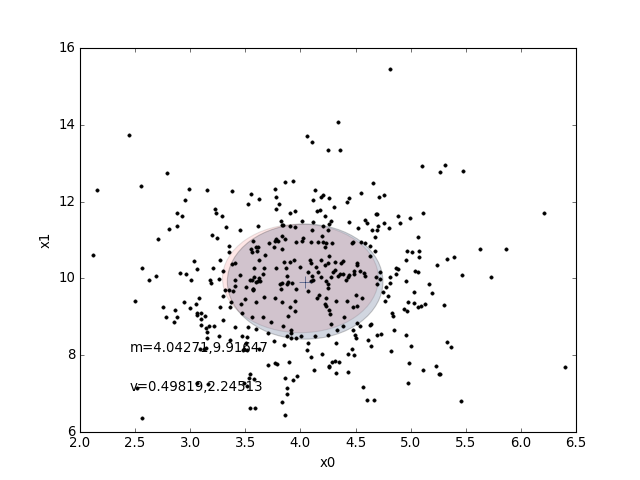

In [11]:
fig, ax = plt.subplots()
plot_fit(fig, ax)

## fit

In [12]:
postmap = compose(scipy_postmap, flat_numericalize_postmap, flatten_parameters, probabilistic_optimizer_postmap)
scipy_kwargs = postmap(model, wrapper=batch, initial_inputs=[])
scipy_kwargs

{'fun': <function schlichtanders.myoptimizers.f_batch>,
 'hess': <function schlichtanders.myoptimizers.f_batch>,
 'jac': <function schlichtanders.myoptimizers.f_batch>,
 'x0': array([ 0.        ,  0.        ,  0.54132485,  0.54132485])}

In [13]:
fit = minimize(
    args=(targets,),
    method="Newton-CG",
    options={'maxiter':100, 'disp':True},
    callback=lambda xs: plot_fit(fig, ax, {model['parameters_flat'][0]:xs}),
    **scipy_kwargs
); fit

Optimization terminated successfully.
         Current function value: 1157.549196
         Iterations: 18
         Function evaluations: 21
         Gradient evaluations: 38
         Hessian evaluations: 18


     fun: 1157.5491962711997
     jac: array([  5.80826692e-07,  -2.66086251e-05,   3.19821900e-04,
        -1.40585810e-05])
 message: 'Optimization terminated successfully.'
    nfev: 21
    nhev: 18
     nit: 18
    njev: 38
  status: 0
 success: True
       x: array([ 4.04271466,  9.91646827, -0.43735822,  2.13318152])

Sometimes we might want to fix fitted model parameters into the model.

In [ ]:
model['parameters_flat'] = [fit.x]

In [ ]:
print model.var.eval()
print model.mean.eval()

# Uniform Distribution

## model

In [ ]:
model = pm.Uniform(output_size=2)
model

In [ ]:
model.map("parameters_positive", reparameterize_map(softplus, softplus_inv), "parameters")
model

## target

In [ ]:
target = pm.Uniform(init_start=[1,4], init_offset=[2,1])
t_sampler = target.function()
t_sampler()

In [ ]:
n_samples = 400
targets = np.array([t_sampler() for _ in xrange(n_samples)])

In [ ]:
targets[:10]

## visualize

In [ ]:
def plot_fit(fig, ax, givens={}, time_delay=0.1):
    ax.clear()
    
    # targets
    ax.plot(targets[:,0], targets[:,1], "k.")
    
    # model
    m_sampler = model.function(givens=givens)
    model_samples = np.array([m_sampler() for _ in xrange(n_samples)])
    ax.plot(model_samples[:,0], model_samples[:,1], "r.")
    fig.canvas.draw()
    time.sleep(time_delay)

In [ ]:
fig, ax = plt.subplots()
plot_fit(fig, ax)

## fit

In [ ]:
postmap = compose(scipy_postmap, flat_numericalize_postmap, flatten_parameters, probabilistic_optimizer_postmap)
scipy_kwargs = postmap(model, wrapper=batch, initial_inputs=[])
scipy_kwargs

In [ ]:
fit = minimize(
    args=(targets,),
    method="Newton-CG",
    options={'maxiter':100, 'disp':True},
    callback=lambda xs: plot_fit(fig, ax, {model['parameters_flat'][0]:xs}),
    **scipy_kwargs
); fit

TODO this does not work. Check whether the gradient is the reason (there is no gradient of the step probability function).